# OAT - Extract France 10-Year Yield Data

This notebook extracts data from the OAT CSV file, specifically the 10-year yield data (Taux de l'Echéance Constante - 10 ans).

The output CSV will contain the date and value columns, with backward fill (bfill) applied to handle missing values.


In [1]:
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')


In [2]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define input and output files
input_file = 'data/oat/Webstat_Export_fr_5385693.csv'
output_file = 'data/oat/FRANCE_10_YEARS_YIELDS.csv'

# Check that the input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"File not found: {input_file}")

print(f"Input file: {input_file}")
print(f"Output file: {output_file}")


Working directory: /workspace
Input file: data/oat/Webstat_Export_fr_5385693.csv
Output file: data/oat/FRANCE_10_YEARS_YIELDS.csv


In [3]:
# Read the CSV file
# The file has header in first row, then 5 metadata rows, then data starts
# Format: date;value1;value2;... (semicolon separated)
# The first column is "Titre :" (dates), third column is "Taux de l'Echéance Constante - 10 ans"
print("Reading CSV file...")
df = pd.read_csv(input_file, sep=';', header=0)

print(f"Data shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head(10))


Reading CSV file...
Data shape: (7708, 11)

Column names:
['Titre :', "Taux de l'Echéance Constante - 1 an", "Taux de l'Echéance Constante - 10 ans", "Taux de l'Echéance Constante - 15 ans", "Taux de l'Echéance Constante - 2 ans", "Taux de l'Echéance Constante - 20 ans", "Taux de l'Echéance Constante - 25 ans", "Taux de l'Echéance Constante - 3 ans", "Taux de l'Echéance Constante - 30 ans", "Taux de l'Echéance Constante - 5 ans", "Taux de l'Echéance Constante - 7 ans"]

First few rows:
                   Titre : Taux de l'Echéance Constante - 1 an  \
0             Code série :   FM.D.FR.EUR.FR2.BB.FRMOYTEC1.HSTA   
1                  Unité :                       Pourcent (PC)   
2              Magnitude :                          Unités (0)   
3  Méthode d'observation :                  Fin de période (E)   
4                 Source :  Banque de France, MTS France (MTS)   
5               2025-12-05                                2,14   
6               2025-12-04                     

In [4]:
# Extract date column (first column "Titre :") and 10-year yield column
date_col_name = df.columns[0]  # "Titre :"
value_col_name = 'Taux de l\'Echéance Constante - 10 ans'

# Check if the column exists
if value_col_name not in df.columns:
    print("Available columns:")
    print(df.columns.tolist())
    raise ValueError(f"Column '{value_col_name}' not found in the CSV file")

df_extracted = df[[date_col_name, value_col_name]].copy()
df_extracted.columns = ['date', 'value']

# Filter out metadata rows (rows where date is not a valid date format)
# Valid dates should be in format YYYY-MM-DD
print(f"\nFiltering out metadata rows...")
print(f"Rows before filtering: {len(df_extracted)}")

print(f"Extracted columns: {df_extracted.columns.tolist()}")
print(f"\nFirst few rows (before filtering):")
print(df_extracted.head(15))



Filtering out metadata rows...
Rows before filtering: 7708
Extracted columns: ['date', 'value']

First few rows (before filtering):
                       date                               value
0              Code série :  FM.D.FR.EUR.FR2.BB.FRMOYTEC10.HSTA
1                   Unité :                       Pourcent (PC)
2               Magnitude :                          Unités (0)
3   Méthode d'observation :                  Fin de période (E)
4                  Source :  Banque de France, MTS France (MTS)
5                2025-12-05                                3,53
6                2025-12-04                                 3,5
7                2025-12-03                                 3,5
8                2025-12-02                                3,49
9                2025-12-01                                3,45
10               2025-11-30                                   -
11               2025-11-29                                   -
12               2025-11-28        

In [5]:
# Convert date column to datetime
# This will automatically filter out metadata rows (they will become NaT)
df_extracted['date'] = pd.to_datetime(df_extracted['date'], format='%Y-%m-%d', errors='coerce')

# Remove rows where date is invalid (metadata rows)
df_extracted = df_extracted[df_extracted['date'].notna()].copy()

print(f"Rows after filtering: {len(df_extracted)}")

# Replace "-" and empty strings with NaN in value column
df_extracted['value'] = df_extracted['value'].replace(['-', ''], pd.NA)

# Convert value column from French format (comma as decimal separator) to numeric
# First replace comma with dot, then convert to numeric
df_extracted['value'] = df_extracted['value'].astype(str).str.replace(',', '.', regex=False)
df_extracted['value'] = pd.to_numeric(df_extracted['value'], errors='coerce')

# Sort by date to ensure proper order
df_extracted = df_extracted.sort_values(by='date').reset_index(drop=True)

print(f"Date range: {df_extracted['date'].min()} to {df_extracted['date'].max()}")
print(f"Total rows: {len(df_extracted)}")
print(f"\nMissing values before bfill:")
print(df_extracted.isnull().sum())
print(f"\nFirst few rows:")
print(df_extracted.head(10))


Rows after filtering: 7703
Date range: 2004-11-03 00:00:00 to 2025-12-05 00:00:00
Total rows: 7703

Missing values before bfill:
date        0
value    2301
dtype: int64

First few rows:
        date  value
0 2004-11-03   3.97
1 2004-11-04   3.93
2 2004-11-05   3.91
3 2004-11-06    NaN
4 2004-11-07    NaN
5 2004-11-08   3.96
6 2004-11-09   3.95
7 2004-11-10   3.92
8 2004-11-11   3.90
9 2004-11-12   3.85


In [6]:
# Apply backward fill (bfill) to fill missing values
# This fills missing values with the next available value
df_extracted['value'] = df_extracted['value'].bfill()

print(f"Missing values after bfill:")
print(df_extracted.isnull().sum())
print(f"\nFinal data preview:")
print(df_extracted.head(10))
print(f"\n...")
print(df_extracted.tail(10))


Missing values after bfill:
date     0
value    0
dtype: int64

Final data preview:
        date  value
0 2004-11-03   3.97
1 2004-11-04   3.93
2 2004-11-05   3.91
3 2004-11-06   3.96
4 2004-11-07   3.96
5 2004-11-08   3.96
6 2004-11-09   3.95
7 2004-11-10   3.92
8 2004-11-11   3.90
9 2004-11-12   3.85

...
           date  value
7693 2025-11-26   3.41
7694 2025-11-27   3.41
7695 2025-11-28   3.41
7696 2025-11-29   3.45
7697 2025-11-30   3.45
7698 2025-12-01   3.45
7699 2025-12-02   3.49
7700 2025-12-03   3.50
7701 2025-12-04   3.50
7702 2025-12-05   3.53


In [7]:
# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Format date as string (YYYY-MM-DD) for CSV output
df_to_save = df_extracted.copy()
df_to_save['date'] = df_to_save['date'].dt.strftime('%Y-%m-%d')

# Save to CSV (format: date,value)
df_to_save.to_csv(output_file, index=False)
print(f"File saved successfully: {output_file}")
print(f"Dimensions: {len(df_to_save)} rows, {len(df_to_save.columns)} columns")
print(f"\nFinal data summary:")
print(df_extracted.describe())


File saved successfully: data/oat/FRANCE_10_YEARS_YIELDS.csv
Dimensions: 7703 rows, 2 columns

Final data summary:
                      date        value
count                 7703  7703.000000
mean   2015-05-21 00:00:00     2.196344
min    2004-11-03 00:00:00    -0.417000
25%    2010-02-10 12:00:00     0.741000
50%    2015-05-21 00:00:00     2.620000
75%    2020-08-27 12:00:00     3.450000
max    2025-12-05 00:00:00     4.860000
std                    NaN     1.476465


Plot saved to: data/oat/FRANCE_10_YEARS_YIELDS_plot.png


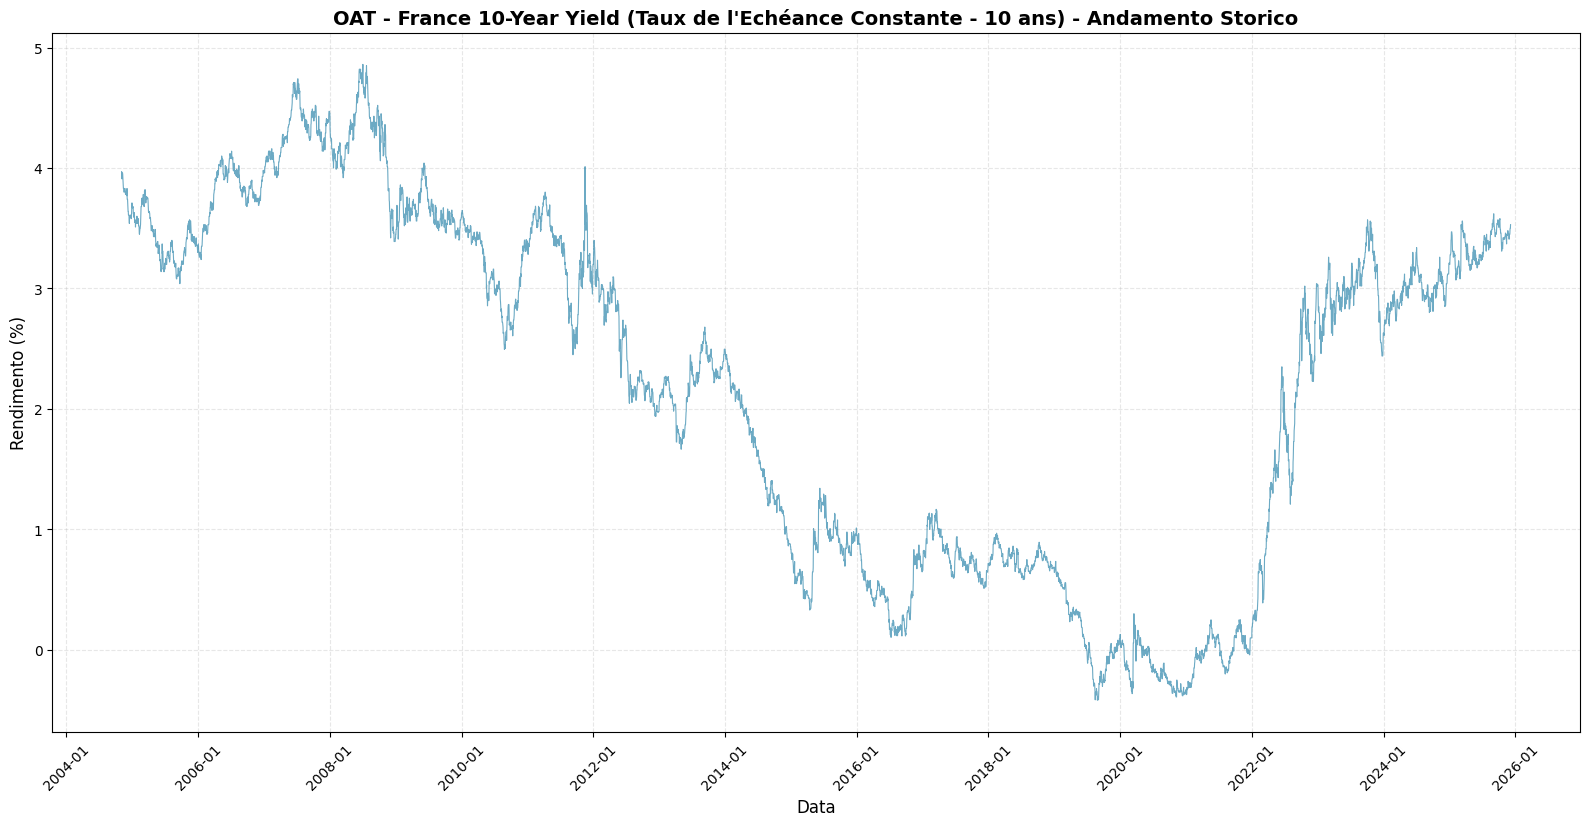

In [8]:
# Create a plot of the data
plt.figure(figsize=(16, 8))
plt.plot(df_extracted['date'], df_extracted['value'], linewidth=0.8, color='#2E86AB', alpha=0.7)
plt.title('OAT - France 10-Year Yield (Taux de l\'Echéance Constante - 10 ans) - Andamento Storico', 
          fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Rendimento (%)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.xticks(rotation=45)

# Save plot
plot_file = os.path.join(os.path.dirname(output_file), 'FRANCE_10_YEARS_YIELDS_plot.png')
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_file}")

plt.show()
